# Scooby Evaluator

## General Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import scipy
import torch
import tqdm
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model

from torch.utils.data import DataLoader

from enformer_pytorch.data import GenomeIntervalDataset

from scooby.modeling import Scooby
from scooby.data import onTheFlyDataset, onTheFlyPseudobulkDataset
from scooby.utils.utils import fix_rev_comp_multiome, undo_squashed_scale, get_pseudobulk_count_pred,get_gene_slice_and_strand

In [3]:
data_path = '/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/'

## scooby

### Functions for Pearson correlation

In [4]:
def stack_and_pearson(x,y):
    return torch.corrcoef(torch.stack([x,y]))[0,1]
batched_pearson = torch.vmap(stack_and_pearson, chunk_size=1)

def predict(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    bs = seqs.shape[0]
    # assert bs == 1
    with torch.no_grad():
        with torch.autocast("cuda"):
            outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
            if bins_to_predict is not None:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = (6143 - bins_to_predict))
            else:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None)
    flipped_version = torch.flip(outputs_rev_comp,(1,-3))
    outputs_rev_comp_test = fix_rev_comp_multiome(flipped_version) #fix_rev_comp2(flipped_version)
    return (outputs + outputs_rev_comp_test)/2

### Load the model

In [5]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


#### Flooby

In [6]:
csb = Scooby.from_pretrained(
    'johahi/neurips-scooby',
    cell_emb_dim=14,
    embedding_dim=1920,
    n_tracks=3,
    return_center_bins_only=True,
    disable_cache=False,
    use_transform_borzoi_emb=True,
)

In [7]:
clip_soft = 5

In [8]:
csb = accelerator.prepare(csb)

In [9]:
context_length  = 524288

### Specify genome

In [10]:
gtf_file = os.path.join(data_path, "gencode.v32.annotation.sorted.gtf.gz")
fasta_file = os.path.join(data_path, 'genome_human.fa')
bed_file = os.path.join(data_path, 'sequences.bed')

### Load neighbors and embedding

In [11]:
base_path = os.path.join(data_path, 'snapatac', 'pseudobulks_fixed/')

In [12]:
sample = 'merged'
neighbors = scipy.sparse.load_npz(os.path.join(data_path, 'scooby_training_data_fixed', 'no_neighbors.npz'))
embedding = pd.read_parquet(os.path.join(data_path, 'scooby_training_data_fixed',  'embedding_no_val_genes_new.pq'))

In [13]:
cell_type_index = pd.read_parquet(os.path.join(data_path,  'scooby_training_data_fixed/celltype_fixed.pq'))
cell_type_index['size'] = cell_type_index['cellindex'].apply(lambda x: len(x))

In [14]:
cell_type_index['celltype'] = cell_type_index['celltype'].str.replace(' ', '_').replace(r"G/M_prog", "G+M_prog").replace("MK/E_prog", "MK+E_prog") #+ '_filtered'
cell_type_index = cell_type_index.sort_values('celltype')

## Eval on Val

### Sequence dataloader 

This only loads the sequences in the right order

In [15]:
gtf_file = f"{data_path}/gencode.v32.annotation.gtf"

In [16]:
from scooby.utils.transcriptome import Transcriptome

In [17]:
transcriptome = Transcriptome(gtf_file)

In [18]:
import polars as pl
filter_val = lambda df: df.filter(True)#
val_ds = GenomeIntervalDataset(
    bed_file = os.path.join(data_path,'scooby_training_data_fixed', 'test_gene_sequences.csv'),
    fasta_file = fasta_file,
    filter_df_fn = lambda df: df.filter((pl.col('column_2') >=0)), 
    return_seq_indices = False,
    shift_augs = (0,0),
    rc_aug = False,
    return_augs = True,
    context_length = context_length,
    chr_bed_to_fasta_map = {}
)
len(val_ds)

2550

In [19]:
val_dataset = onTheFlyDataset(
    None,
    None,
    neighbors,
    embedding,
    val_ds,
    get_targets= False,
    random_cells = False,
    cells_to_run = None, 
    clip_soft = clip_soft,
    )
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 1)
csb, val_loader = accelerator.prepare(csb, val_loader)
clip_soft

5

### Target dataloader on bigwig pseudobulk files

In [20]:
val_dataset_targets = onTheFlyPseudobulkDataset(
    cell_types = cell_type_index['celltype'].values,
    ds = val_ds, 
    base_path = base_path,
)

### Get cell conv_weights for all cells

In [21]:
csb.eval()
cell_indices  = []
size_factors_per_ct = []
for _, row in tqdm.tqdm(cell_type_index.iterrows(),disable = True):
    cell_indices.append(
        torch.from_numpy(
            np.vstack(
                embedding.iloc[row['cellindex']]['embedding'].values # gets embeddings of all cells of the cell type
                )
            ).unsqueeze(0)
        ) # prep cell_embeddings

# get conv weights and biases for all cells sorted by cell type in a list
cell_emb_conv_weights_and_biases = []
for cell_emb_idx in tqdm.tqdm(cell_indices, disable = True):
    cell_emb_idx = cell_emb_idx.cuda()
    conv_weights, conv_biases = csb.forward_cell_embs_only(cell_emb_idx)
    cell_emb_conv_weights_and_biases.append((conv_weights.to(torch.float16), conv_biases.to(torch.float16)))


### Get counts over exons

In [22]:
num_neighbors = 1

all_outputs, all_targets = [], []
val_dataset_target_loader = iter(DataLoader(val_dataset_targets, batch_size=1, shuffle = False, num_workers = 4))

# iterate over all gene sequences
for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):
    gene_slice, strand = get_gene_slice_and_strand(transcriptome, val_dataset_targets.genome_ds.df[i, 'column_4'], val_dataset_targets.genome_ds.df[i, 'column_2'], span = False)
    # continue
    targets = (next(val_dataset_target_loader)[2]).float().cuda()
    if len(gene_slice) == 0:
        continue
    
    bs = x[0].shape[0]
    seqs = x[0].cuda().permute(0,2,1)
    stacked_outputs = []

    stacked_outputs = get_pseudobulk_count_pred(
        csb = csb, 
        seqs = seqs, 
        cell_emb_conv_weights_and_biases = cell_emb_conv_weights_and_biases, 
        gene_slice = gene_slice,
        strand = strand, 
        model_type = "multiome",
        predict = predict,  
        clip_soft = clip_soft, 
        num_neighbors = 1
    )
    temp_stack = []
    all_outputs.append(stacked_outputs)
    if strand == '+':
        all_targets.append(undo_squashed_scale(targets[0, gene_slice, ::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())
    elif strand == '-':
        all_targets.append(undo_squashed_scale(targets[0, gene_slice, 1::2], clip_soft=384).sum(axis=0).detach().clone().cpu().squeeze())

    
all_outputs, all_targets = torch.vstack(all_outputs).clone().numpy(force=True),torch.vstack(all_targets).clone().numpy(force=True)

100%|██████████| 2550/2550 [17:32<00:00,  2.42it/s]


Text(0, 0.5, 'Target')

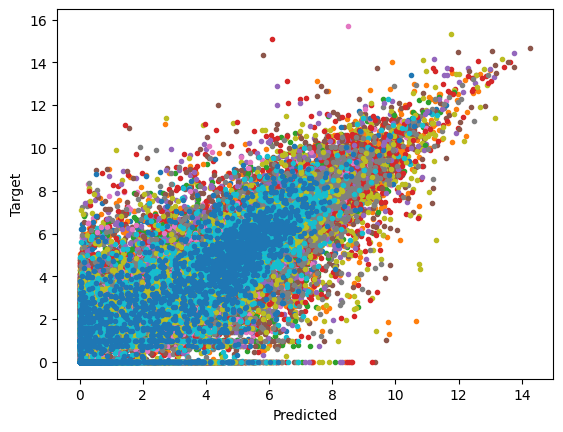

In [23]:
import matplotlib.pyplot as plt
plt.plot(np.log2((all_outputs+1)), np.log2(all_targets+1), '.')
plt.xlabel('Predicted')
plt.ylabel('Target')

In [24]:
spearmanr = [
    scipy.stats.spearmanr(np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])
]
pearsonr =  [
    scipy.stats.pearsonr (np.log2(all_outputs[:, i] + 1), 
                          np.log2(all_targets[:, i] + 1))[0] for i in range(all_outputs.shape[1])]

In [25]:
np.mean(pearsonr), np.median(pearsonr) # np.mean(pearsonr), np.median(pearsonr) with normos (0.8695861071966647, 0.8775566542956221)

(np.float32(0.8594968), np.float32(0.8618465))

Text(0.5, 1.0, 'Count, across gene comparison')

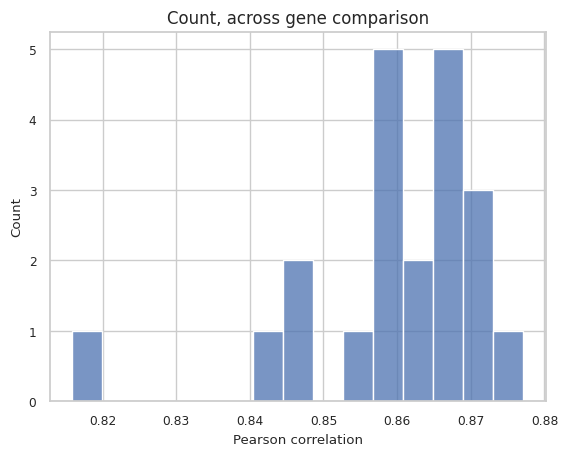

In [26]:
import seaborn as sns
sns.set_theme(style="whitegrid",  font_scale=0.8)
sns.histplot(pearsonr, bins = 15)
plt.xlabel('Pearson correlation')
plt.title('Count, across gene comparison',  size = 12)

In [27]:
# log2(x+1)
counts_predicted_log = np.log2(pd.DataFrame(all_outputs) + 1)  #pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_predicted_log.parquet")# np.log2(pd.DataFrame(all_outputs) + 1) 
#counts_predicted_log = counts_predicted_log.drop(16, axis = 1) #remove other myloids?
# substract mean per gene across all cell types
counts_predicted_log = counts_predicted_log - counts_predicted_log.mean(axis=0)

#substract mean per cell type across all genes
counts_predicted_log = counts_predicted_log.subtract(counts_predicted_log.mean(axis=1), axis=0)
counts_target_log =np.log2(pd.DataFrame(all_targets) + 1)# pd.read_parquet("/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/eval/count_target_log.parquet")# np.log2(pd.DataFrame(all_targets) + 1)
#counts_target_log = counts_target_log.drop(16, axis = 1) #remove other myloids?
counts_target_log = counts_target_log - counts_target_log.mean(axis=0)

counts_target_log = counts_target_log.subtract(counts_target_log.mean(axis=1), axis=0)

In [28]:
import matplotlib as mp
font_size=  12
mp.rcParams['axes.labelsize'] = font_size
mp.rcParams['axes.linewidth'] = font_size / 24.
mp.rcParams['axes.titlesize'] = font_size
mp.rcParams['legend.fontsize'] = font_size
mp.rcParams['xtick.labelsize'] = font_size
mp.rcParams['ytick.labelsize'] = font_size

0.5291457


Text(0.5, 0, 'Predicted')

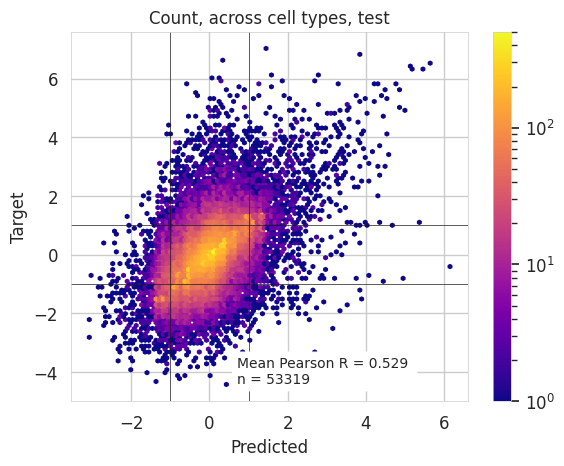

In [29]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
ax = plt.hexbin(x=counts_predicted_log.values.ravel(), y=counts_target_log.values.ravel(), mincnt=1, cmap='plasma', norm=LogNorm())
plt.axvline(1, c='k', linewidth = font_size/24)
plt.axvline(-1,c='k', linewidth = font_size/24)
plt.axhline(1,c='k', linewidth = font_size/24)
plt.axhline(-1,c='k', linewidth = font_size/24)
plt.colorbar()
plt.ylabel('Target')
plt.title('Count, across cell types, test')
p=scipy.stats.pearsonr(counts_predicted_log.values.ravel(), counts_target_log.values.ravel())[0]
# plt.text(2.5,-5, f"Pearson corr.: {np.round(p, 3)}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.text(.7,-4.4, f"Mean " + r"Pearson R"+ f" = {p:.3f} \nn = {len(counts_predicted_log.values.ravel())}", bbox=dict(facecolor='white', edgecolor='white', boxstyle='round'), fontdict={'size' : 10})
print(p)
plt.xlabel('Predicted')
#plt.savefig("Fig2E.svg",bbox_inches="tight")